In [1]:
from fairlearn.metrics import MetricFrame

In [2]:
import io
from collections import Counter

import numpy as np
import pandas as pd
import scipy.io
from statistics import mode
import sklearn.model_selection
import sklearn.tree
import seaborn as sns

from fairlearn.widget import FairlearnDashboard
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate

import pydot
import multiprocessing as mp
from sklearn.feature_extraction import DictVectorizer

/Users/wesley/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df_por, df_mat = pd.read_csv('student-por.csv', sep=';'), pd.read_csv('student-mat.csv', sep=';')

## Define the threshold

In [4]:
def generate_pnp(df, g_1=0.3, g_2=0.3, g_3=0.4, threshold=11):
    """
    Augmented the original dataframe with a "pass" column.
    """    
    # Sanity Check.
    assert g_1 + g_2 + g_3 == 1, "The sum of percentages should be 1"
    assert 0 < threshold < 20, "Threshold need to be between 0 and 20"
    
    # Augmenting the dataframe.
    df['pass'] = df.apply(lambda row: 1 
                                 if g_1*row['G1'] + g_2*row['G2'] + g_3*row['G3'] >= threshold
                                 else 0, axis=1)

In [13]:
generate_pnp(df_por)
df_pnp = df_por.drop(['G1', 'G2', 'G3'], axis=1)
df_pnp.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,pass
260,GP,F,16,U,GT3,T,1,2,other,other,...,yes,no,5,3,5,1,2,5,4,1
428,MS,F,15,R,LE3,T,2,1,at_home,other,...,no,no,1,3,4,1,1,1,0,0
143,GP,F,18,U,GT3,A,3,2,other,services,...,yes,yes,4,3,3,5,1,5,10,1
540,MS,F,17,U,GT3,T,3,2,at_home,other,...,no,yes,4,3,3,2,2,1,5,0
259,GP,F,17,U,LE3,T,1,1,at_home,at_home,...,yes,yes,4,3,2,1,2,4,10,0


## Selecting sensitive attributes

In [14]:
# Selecting sensitive attributes
sex = df_pnp['sex']
address = df_pnp['address']

In [28]:
pstatus = df_pnp['Pstatus']

In [15]:
sex.value_counts()

F    383
M    266
Name: sex, dtype: int64

In [16]:
address.value_counts()

U    452
R    197
Name: address, dtype: int64

In [17]:
y = df_pnp['pass']
X = df_pnp.drop(['pass'], axis=1)

In [20]:
X = pd.get_dummies(X)
X.shape

(649, 56)

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
clf.fit(X, y) # no train test split yet.
y_pred = clf.predict(X)


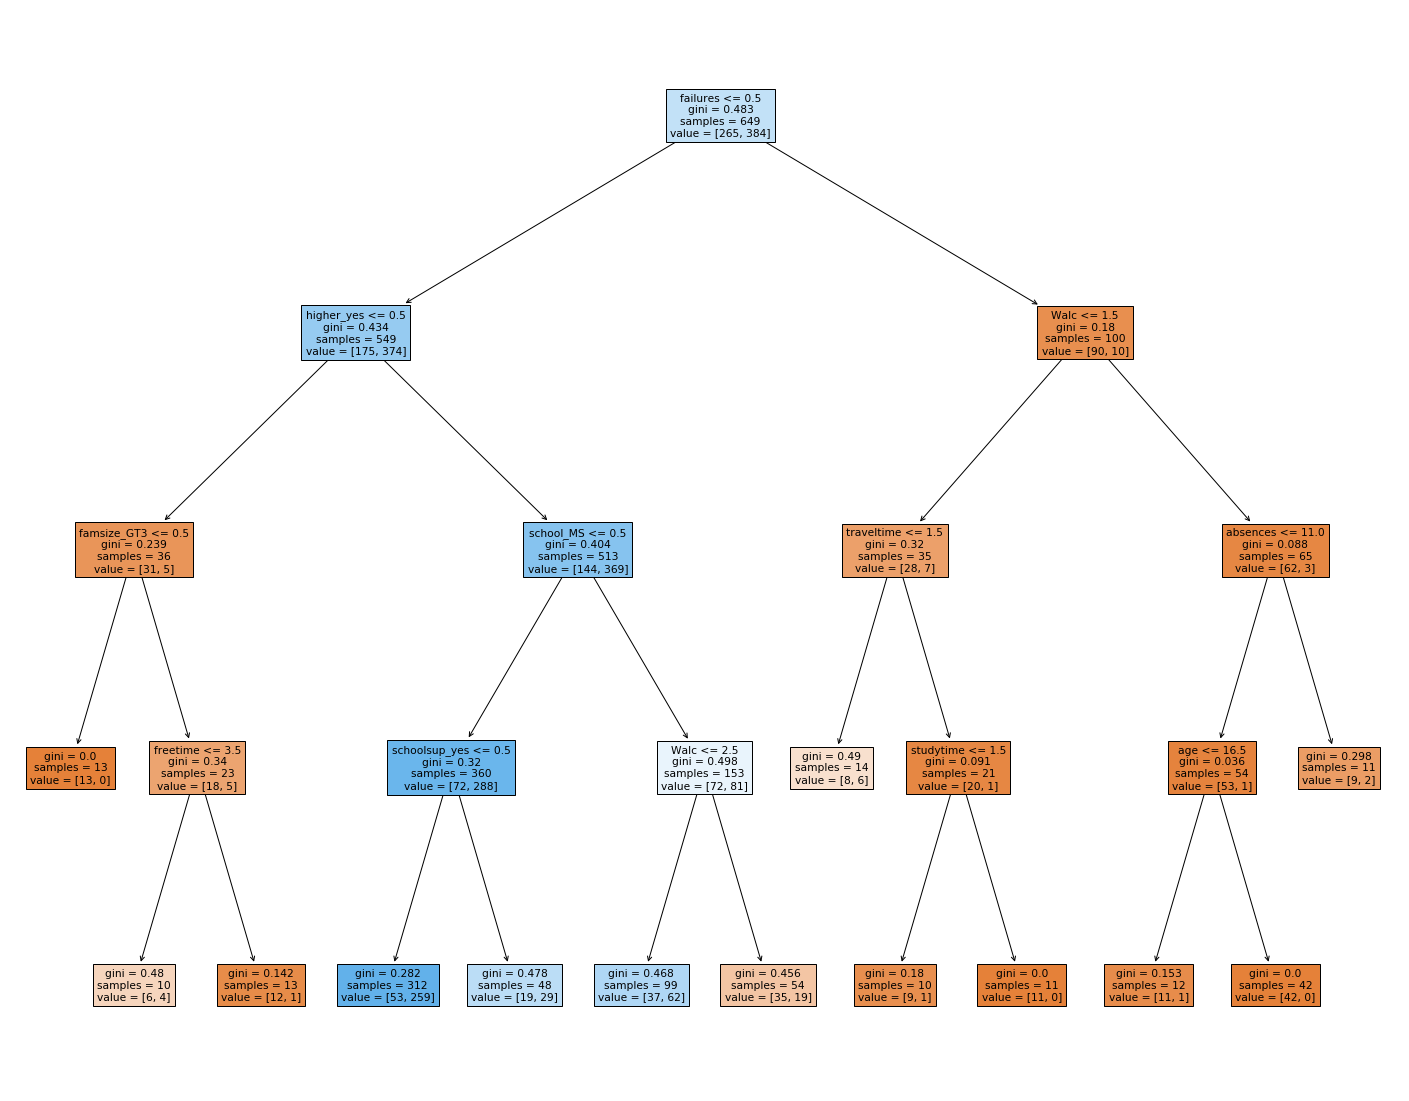

In [38]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,20))
ax = sklearn.tree.plot_tree(clf, feature_names = X.columns, 
                   filled=True)
fig.savefig('before_tree.png')

In [23]:
print(gm.overall, gm.by_group)

0.7796610169491526 sex
F    0.780679
M    0.778195
Name: accuracy_score, dtype: object


In [29]:
gm_sex = MetricFrame(accuracy_score, y, y_pred, sensitive_features=sex)
gm_add = MetricFrame(accuracy_score, y, y_pred, sensitive_features=address)
gm_p = MetricFrame(accuracy_score, y, y_pred, sensitive_features=pstatus)

<font size=3.1>
Linking back to the EDA part: how do data scientsits choose the feature to investigate?

In [26]:
print(gm_sex.overall, gm_sex.by_group)

0.7796610169491526 sex
F    0.780679
M    0.778195
Name: accuracy_score, dtype: object


In [27]:
print(gm_add.overall, gm_add.by_group)

0.7796610169491526 address
R    0.730964
U    0.800885
Name: accuracy_score, dtype: object


In [30]:
print(gm_p.overall, gm_p.by_group)

0.7796610169491526 Pstatus
A        0.75
T    0.783831
Name: accuracy_score, dtype: object


### Start with 

Frinction: 

fit several attributes in at the same time.

In [35]:
FairlearnDashboard(sensitive_features=address,
                   sensitive_feature_names=['address'],
                   y_true=y,
                   y_pred={"initial model": y_pred}) 

FairlearnWidget(value={'true_y': [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1…

In [ ]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
np.random.seed(15)
constraint = DemographicParity()
clf = 